## Task 3: Dish Recognition ##

We start the second task in the capstone project with standard step of Data Science: data preparation. Particularly we are going to load JSON file as Apache Spark DataFrame (https://spark.apache.org/docs/latest/sql-programming-guide.html) and extract all reviews that belong to businesses in the category 'American (New)'. The result we're going to write to txt file in order to pass through SegPhrase framework.

In [2]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf, col, lit
from pyspark.sql.types import BooleanType

basePath = 'dataminingcapstone-001'
workingDir = os.path.join(os.curdir, basePath)

In [219]:
sqlContext = SQLContext(sc)

targetDir = os.path.join(workingDir, 'yelp_dataset_challenge_academic_dataset')

businessJSON = os.path.join(targetDir, 'yelp_academic_dataset_business.json')
businessDF = sqlContext.read.json(businessJSON)

reviewsJSON = os.path.join(targetDir, 'yelp_academic_dataset_review.json')
reviewsDF = sqlContext.read.json(reviewsJSON)

contains = udf(lambda xs, val: val in xs, BooleanType())
restaurantsDF = businessDF[contains(businessDF.categories, lit(u'American (New)'))]

selectedReviewsDF = reviewsDF.join(restaurantsDF,\
                                       restaurantsDF.business_id == reviewsDF.business_id)    
rewiewsRDD = selectedReviewsDF.select("text").map(lambda x: x.text)

In [220]:
from string import maketrans

reviewsIt = rewiewsRDD.toLocalIterator()
reviewsFile = os.path.join(workingDir, 'american.txt')

count = 0
with open(reviewsFile, 'w') as f:
    for line in reviewsIt:
        line = ' '.join(line.encode('utf-8').split())
        f.write(line)
        f.write('\n')
        count += 1
        
print 'total written lines: {}'.format(count)

total written lines: 94183


The first result of SegPhrase framework is in salinet.csv file. We need only first 10,000 phrases.

In [ ]:
import csv

salientCSV = os.path.join(workingDir, 'salient.csv')
submissionFile = os.path.join(workingDir, 'submission.txt')

with open(submissionFile, 'w') as out, open(salientCSV, 'rb') as csvfile:
    out.write('American\n')
    
    i = 0
    salientReader = csv.reader(csvfile)
    
    for row in salientReader:
        out.write(row[0].replace('_', ' '))
        out.write('\n')
      
        i += 1
        if i >= 10000:
            print row
            break

Now let's analyse what is the distrubution of phrases in the result file. To do that we're going to parse strings from the file and draw a simple line chart. 

In [4]:
import csv

salientCSV = os.path.join(workingDir, 'salient.csv')

with open(salientCSV, 'rb') as csvfile:
    salientReader = csv.reader(csvfile)

    ngrams = [(row[0].replace('_', ' '), float(row[1])) for row in salientReader]

In [5]:
import numpy as np

data = np.array([item[1] for item in ngrams])

print data

[  9.99428406e-01   9.99387392e-01   9.99376107e-01 ...,   3.05813000e-05
   3.05813000e-05   3.05813000e-05]


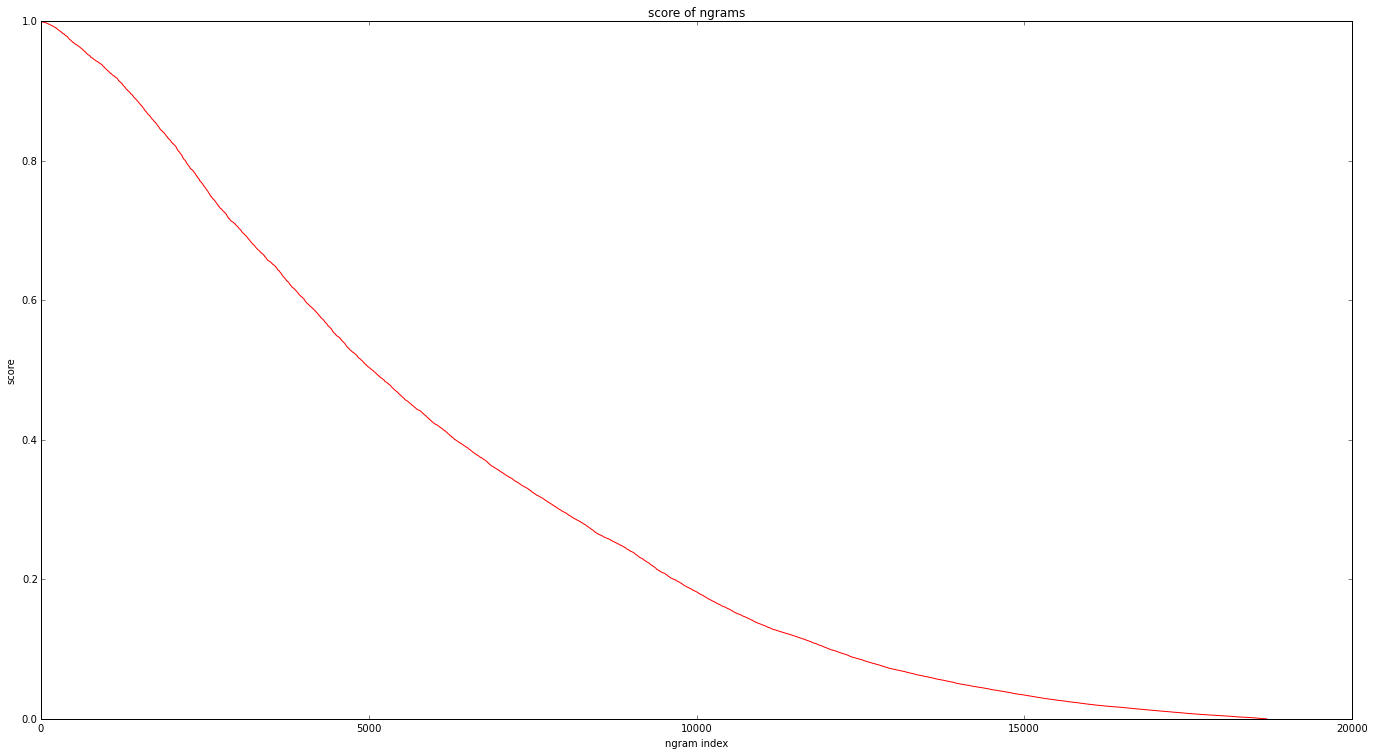

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(data, color='r')

plt.xlabel('ngram index')
plt.ylabel('score')

plt.title('score of ngrams')

plt.gcf().set_size_inches(23.5, 12.5)

plt.show()

## Enrich the labels from external sources ##

Add list of hamburgers

In [159]:
import requests
from pyquery import PyQuery

response = requests.get('https://en.wikipedia.org/wiki/List_of_hamburgers')
jQuery = PyQuery(response.content)

list_of_dishes = []
for i in jQuery("table.wikitable.sortable tr td:nth-child(1)"):
    if i.text == None:
        i = i.find('a')
    list_of_dishes.append(i.text)

Add list of American sandwiches

In [10]:
import requests
from pyquery import PyQuery

response = requests.get('https://en.wikipedia.org/wiki/List_of_sandwiches')
jQuery = PyQuery(response.content)

for i in jQuery("div ul li a"):
    if i != None and i.text != None:
        #list_of_dishes.append(i.text.lower())
        print i.text.lower() + ' sandwich'

hard boiled eggs sandwich
egg salad sandwich
fried sandwich
scrambled egg sandwich
roe spread sandwich
eggs benedict sandwich
hollandaise sauce sandwich
list of american sandwiches sandwich
list of hamburgers sandwich
list of submarine sandwich restaurants sandwich
sandwich bread sandwich
african sandwich
american sandwich
southern united states sandwich
arab dishes sandwich
argentine sandwich
bangladeshi sandwich
brazilian sandwich
burmese sandwich
chadian sandwich
chinese sandwich
colombian sandwich
cuban sandwich
ecuadorian sandwich
english sandwich
ethiopian sandwich
filipino sandwich
french sandwich
german sandwich
greek sandwich
hawaiian sandwich
hungarian sandwich
indian sandwich
indonesian sandwich
irish sandwich
israeli sandwich
italian sandwich
sicilian sandwich
jamaican sandwich
japanese sandwich
jewish sandwich
jordan sandwich
korean sandwich
malaysian sandwich
maltese sandwich
mexican sandwich
moroccan sandwich
nepalese dishes sandwich
nigeria sandwich
pakistani sandwich
p

Add list of American bread

In [161]:
import requests
from pyquery import PyQuery

response = requests.get('https://en.wikipedia.org/wiki/List_of_American_breads')
jQuery = PyQuery(response.content)

for i in jQuery("div.mw-content-ltr ul:nth-child(11) li a:first-child"):
    if i != None and i.text != None:
        list_of_dishes.append(i.text.lower())

Add list of American cheese

In [162]:
import requests
from pyquery import PyQuery

response = requests.get('https://en.wikipedia.org/wiki/List_of_American_cheeses')
jQuery = PyQuery(response.content)

#mw-content-text > ul:nth-child(9) > li:nth-child(1) > a
for i in jQuery("div.mw-content-ltr ul:nth-child(9) li a:first-child"):
    if i != None and i.text != None:
        list_of_dishes.append(i.text.lower())

In [168]:
labelFile = os.path.join(workingDir, 'american.label')

with open(labelFile, 'a') as out:
    for i in list_of_dishes:
        out.write('{}\t{}\n'.format(i.encode('utf-8'), '1'))      

In [190]:
import csv

salientCSV = os.path.join(workingDir, 'salient2.csv')

with open(salientCSV, 'rb') as csvfile:
    salientReader = csv.reader(csvfile)

    ngrams = [(row[0].replace('_', ' '), float(row[1])) for row in salientReader]

In [191]:
import numpy as np

data = np.array([item[1] for item in ngrams])

print data

[  9.97745837e-01   9.97408504e-01   9.97320441e-01 ...,   2.22312000e-05
   2.22312000e-05   2.22312000e-05]


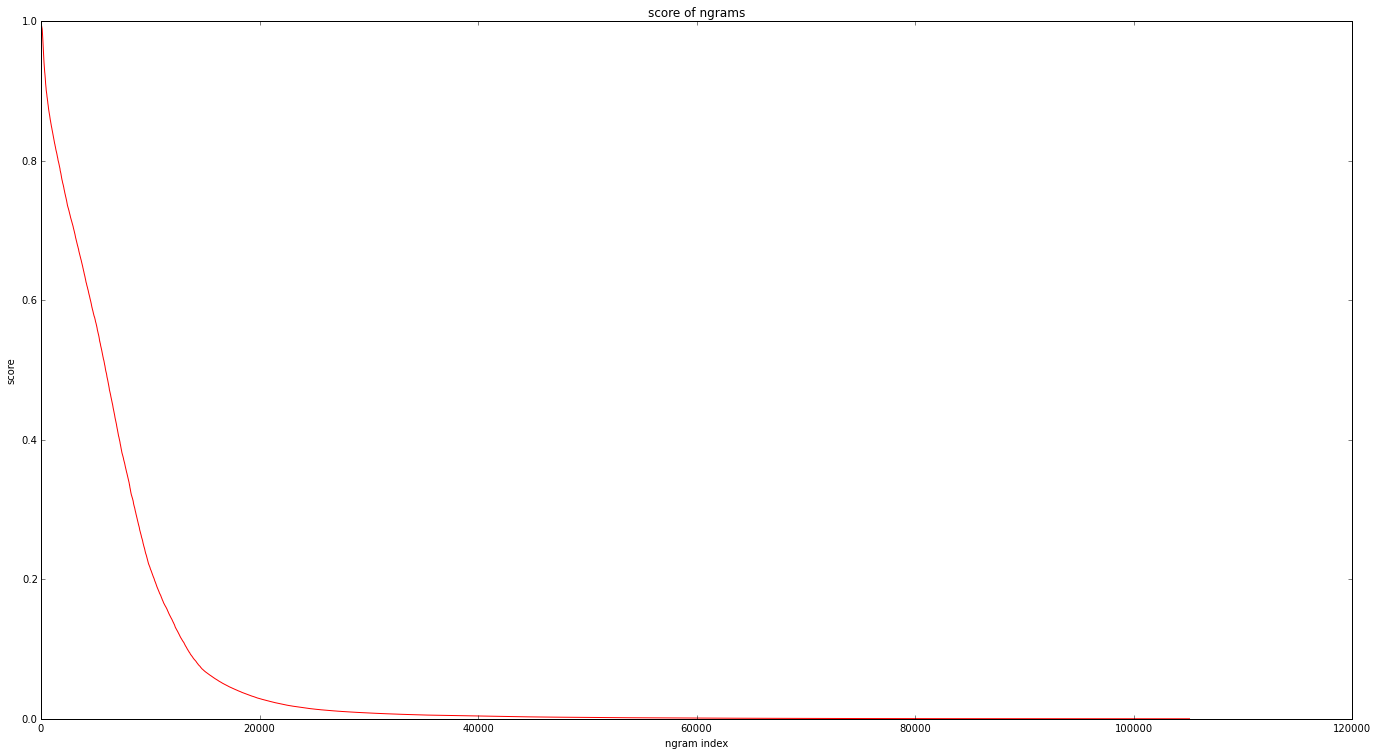

In [192]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(data, color='r')

plt.xlabel('ngram index')
plt.ylabel('score')

plt.title('score of ngrams')

plt.gcf().set_size_inches(23.5, 12.5)

plt.show()

In [5]:
import csv

salientCSV = os.path.join(workingDir, 'salient2.csv')
submissionFile = os.path.join(workingDir, 'submission2.txt')

dishes = []
with open(submissionFile, 'w') as out, open(salientCSV, 'rb') as csvfile:
    out.write('American\n')
    
    i = 0
    salientReader = csv.reader(csvfile)
    
    for row in salientReader:
        dish = row[0].replace('_', ' ').replace('the ', '').replace('a ', '')
        dishes.append(dish)
        out.write(dish)
        out.write('\n')
      
        i += 1
        if i >= 10000:
            print row
            break

['the_main_ingredient', '0.2164634619']


In [4]:
import string

remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
wordsRDD = rewiewsRDD.map(lambda x: x.translate(remove_punctuation_map).lower()).map(lambda row: row.split(" "))

NameError: name 'rewiewsRDD' is not defined

In [198]:
from pyspark.mllib.feature import Word2Vec

word2vec = Word2Vec()
model = word2vec.fit(wordsRDD)

In [218]:
words = ['hotdog', 'potato', 'benedict', 'pudding', 'cake', 'burger', 'sandwich', 'salad']

for word in words:
    print 'synonyms for word: \'{}\''.format(word)
    synonyms = model.findSynonyms(word, 4)
    for synonym, cosine_distance in synonyms:
        print("\t{}: {}".format(synonym.encode('utf-8'), cosine_distance))

synonyms for word: 'hotdog'
	coney: 0.573703055271
	brat: 0.570953088025
	igby: 0.548325171401
	bratwurst: 0.544862319612
synonyms for word: 'potato'
	potatoe: 2.61149656319
	pototoes: 2.36363775867
	shoestring: 2.303864645
	fries: 2.21013886467
synonyms for word: 'benedict'
	scrambled: 2.17427912151
	eggs: 2.07123057532
	benny: 2.05913604721
	poached: 2.0306207359
synonyms for word: 'pudding'
	monkey: 2.92108109017
	banana: 2.51004236852
	toffee: 2.49030032025
	cinnamon: 2.46451821869
synonyms for word: 'cake'
	molten: 2.27096081837
	brownie: 2.23950596533
	lava: 2.1807438547
	chocolate: 2.16466717983
synonyms for word: 'burger'
	patty: 1.26957582773
	hamburger: 1.23061162685
	: 1.1713456998
	kobe: 1.10203355336
synonyms for word: 'sandwich'
	panini: 1.7340248868
	sandwhich: 1.729340555
	wrap: 1.65246206304
	fajita: 1.58707608462
synonyms for word: 'salad'
	ceasar: 1.68157890172
	caesar: 1.61508663488
	wedge: 1.54579499421
	saladfresh: 1.54419249867


In [217]:
sandwich_matches = [x for x in dishes if 'sandwich' in x]
for s in sandwich_matches:
    print s.replace('sandwich', 'panini')

chicken panini
steak panini
pulled pork panini
club panini
brisket panini
cuban panini
ice cream panini
panini with sweet potato fries
turkey panini
bahn mi panini
salad panini
panini bread
veggie panini
grilled cheese paninies
grilled veggie panini
prime rib panini
prosciutto panini
meatloaf panini
portobello panini
buffalo chicken panini
fried egg panini
french dip panini
turkey club panini
short rib grilled cheese panini
chicken salad panini
grilled cheese panini
ruben panini
rosemary chicken panini
corned beef panini
chicken pesto panini
eggplant panini
beer bread paninies
mahi panini
ham panini
short rib panini
cranberry panini
chicken paninies
cheesesteak panini
salmon panini
caprese panini
the portobello mushroom panini
biloxi buttermilk fried chicken panini
mahi mahi panini
crispy chicken panini
egg panini
half panini
breakfast paninies
philly panini
pita panini
turkey pastrami panini
vietnamese panini
cajun chicken panini
bbq pork panini
philly cheese steak panini
crab cake pa

In [ ]:
import csv

salientCSV = os.path.join(workingDir, 'salient3.csv')
submissionFile = os.path.join(workingDir, 'dishes.txt')

dishes = []
with open(submissionFile, 'w') as out, open(salientCSV, 'rb') as csvfile:
#    out.write('American\n')
    
    i = 0
    salientReader = csv.reader(csvfile)
    
    for row in salientReader:
        dish = row[0].replace('_', ' ').replace('the ', '').replace('a ', '')
        dishes.append(dish)
        out.write(dish)
        out.write('\n')
      
        i += 1
        if i >= 10000:
            print row
            break